In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
## Testing installation

mycsv = '../data/dist_tower.csv'
# mycsv = 'dist_tower_na.csv'
target = 'yield'
mytimecsv = '../data/time_dist_tower.csv' #contains time index as in JMP outpout

df = pd.read_csv(mycsv)#  parse_dates = [time_column] # JMP does NOT parse dates
t = pd.read_csv(mytimecsv)

col = list(df.columns)
col.remove(target)
# col.remove(time_column) # user may introduce the date as X 

In [3]:
X = df[col].copy()
y = df[target].copy() 
#t = df[time_column].copy()  

W = pd.Series(np.random.rand(len(y)),name='weight') 

# JMP loads everything as dataframe
y = y.to_frame() 
#t = t.to_frame()
W = W.to_frame()

# JMP 15 bug ignores NaN values if passed as single column
# for the moment, JSL will pass single columns as double

y = pd.concat([y, y], axis=1)

# File containing time csv has already a duplicated column
# t = pd.concat([t, t], axis=1)

W = pd.concat([W, W], axis=1)

In [4]:
del(df)
# del(W) # debugging code without W
# del(t) # debugging code without W

# Analysis STARTS

In [5]:
# import numpy as np
# import pandas as pd
import shap
from lightgbm.sklearn import LGBMRegressor
import time
import re

In [6]:
__author__ = 'Francisco Navarro, Juline Gillard'
__url__ = 'https://github.com/industrial-data/predictor-explainer'
__copyright__ = 'BSD-Clause 3'
__version__ = '2022.09.12'
__maintainer__ = 'Francisco Navarro, Carlos Perez-Galvan'
__status__ = 'beta'


In [7]:
# JMP loads everything as data frames

def rename_df_columns(my_dataframe):
    '''Light GBM does not support special JSON Characters in column names yet
    This function susbtitues by _ all characters in column names that are not letters or numbers'''
    my_dataframe = my_dataframe.rename(columns = lambda str_column:re.sub(r'[^A-Za-z0-9_]+','_', str_column))
        
    # Once fixed, the following reg. exp. will keep special JSON charaters
    # my_data_frame = my_data_frame.rename(columns = lambda str_column:re.sub(r'[^\x00-\x7F]+','', str_column))
    
    return my_dataframe


y = rename_df_columns(y) # removing special characters
y = y.iloc[:, 0] # converting df to series

# Tests

# del(t)
# del(W)

# For debugging only (fewer columns)
#minimum_columns = ['Temp1', 'FlowC1', 'PressureC1']
#X = X[minimum_columns]

tic = time.time()

# Removes X columns that are non numeric (e.g. dates in X)
X = X.select_dtypes(include=np.number)
X['SHAP_row_index'] = range(1, len(X) + 1)
X = rename_df_columns(X) # removing special characters


try:
    t
except NameError:
    t_exists = False
else:
    t_exists = True
    t = rename_df_columns(t) # removing special characters
    
    #t.to_csv('C:\Temp\JMP_time.csv')
    
    t.iloc[:,0] = pd.to_datetime(t.iloc[:,0], unit='s', origin=pd.Timestamp('1904-01-01'))
    t = t.iloc[:, 0] # converting to series
    
    
try:
    W
except NameError:
    W_exists = False
else:
    W_exists = True
    W = rename_df_columns(W) # removing special characters
    
    #W.to_csv('C:\Temp\JMP_weight.csv')
    W = W.rename(columns = lambda str_column:re.sub(r'[^A-Za-z0-9_]+','_', str_column))
    W = W.iloc[:, 0] # converting to series
    


    
print('X head: \n', X.head())
print('X tail: \n', X.tail())
print('y: \n', y)

assert (len(X) == len(y) ), 'Number of rows of X, y does not match!'

#check if NaN exist in Y, W, t and remove corresponding X 
y.dropna(inplace=True)
index_not_nan = y.index
X = X.loc[index_not_nan,:]

if t_exists:
    t = t[index_not_nan]
    t.dropna(inplace=True)
    t_index_not_nan = t.index
    
    y = y[t_index_not_nan]
    X = X.loc[t_index_not_nan,:]
    assert (len(X) == len(y) == len(t)), 'Number of rows of X, y and t does not match'

if W_exists:
    W = W[index_not_nan] 
    W.fillna(0)
    W = (W-W.min())/(W.max()-W.min())
    assert (len(X) == len(y) == len(W)), 'Number of rows of X, y and W does not match'
    weights = W
    
print('X head (after dropping NaN): \n', X.head())
print('X tail (after dropping NaN): \n', X.tail())
print('y (after dropping NaN): \n', y)    

diff_period = 1

X_diff = X.diff(periods = diff_period, axis = 0).copy()
X_diff.columns = ['Diff_'+col for col in X_diff.columns]
X = pd.concat([X, X_diff], axis=1)

toc = time.time() - tic
print('Loading data time [s]:', round(toc, 2))
tic = time.time()

X head: 
       OC1   Temp11    Temp12  PressureC1    TempC1     Temp1    FlowC1  \
0  3.1033  30.8983  489.9900    215.0627  100.2204  139.9857  432.0636   
1  4.7408  31.9099  480.2888    205.0999  100.2297  131.0470  487.4029   
2  4.2925  29.9165  486.6190    205.0304  100.3084  118.2666  437.3516   
3  4.4558  30.6229  491.1304    205.2561   95.5766  118.1769  481.8314   
4  3.4600  29.4977  487.6475    205.0883   92.9052  120.7891  412.6471   

      Temp2     Temp3    TempC2  ...      Temp7     Temp8   FlowC9   FlowC2  \
0  377.8119  492.1353  490.1459  ...  1129.6040  522.4728  86.6133  69.9017   
1  371.3060  482.2100  480.3128  ...  1082.9395  516.0140  97.6100  69.6900   
2  378.4483  488.7266  487.0040  ...  1076.9067  514.6193  88.4967  70.5867   
3  378.0028  493.1481  491.1137  ...  1078.9117  519.3823  95.3483  70.2167   
4  377.8871  490.2486  488.6641  ...  1087.4271  508.6756  82.9533  69.6567   

      Temp9    Temp10  FlowC3   FlowC4  VapourPressure  SHAP_row_index

In [8]:
#add some time features

print('Starting date parsing')

if t_exists: # In case user does not introduce time
    print(t.head())
    
    # Check first five years in time column
    # if index was used as time year will be around 1904 (starting date in JMP)
    
    is_date_correct = (1960 <= np.nanmean(t.dt.year[0:5]))
                       
    if False:
        print('Creating time features')
    
        #t = t[diff_period:len(t)] # TODO WHY?
    
        day_of_month = True
        day_of_week = True
        day_of_year = True
        week = True
        week_of_month = True
        month = True
        quarter = True
        semester = True
        year = True
        hour = True
        minute = True

        if day_of_month:
            X['day_of_month'] = t.dt.day
        if day_of_week:
            X['day_of_week'] = t.dt.dayofweek
        if day_of_year:
            X['day_of_year'] = t.dt.dayofyear
        if week:
            X['week_of_year'] = t.dt.isocalendar().week.astype(np.int)
        if week_of_month:
            X['week_of_month'] = t.dt.day.divide(7).apply(np.floor)
        if month:
            X['month'] = t.dt.month
        if quarter:
            X['quarter'] = t.dt.quarter
        if semester:
            X['semester'] = t.dt.month.divide(6).apply(np.ceil) # NEW
        if year:
            X['year'] = t.dt.year
        if hour:
            X['hour'] = t.dt.hour
        if minute:
            X['minute'] = t.dt.minute

toc = time.time() - tic
print('Date parsing finished, total time [s]:', round(toc, 2))
tic = time.time()

Starting date parsing
0   2016-08-21
1   2016-08-23
2   2016-08-26
3   2016-08-29
4   2016-08-30
Name: Date, dtype: datetime64[ns]
Creating time features
Date parsing finished, total time [s]: 0.06


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [9]:
n_trees = 1000 # number of trees in the forest

signal_to_noise = 3 # ratio to remove non features near the noise

#add noise
normalNoise = np.random.normal(size = len(X))
uniNoise = np.random.uniform(size = len(X))

#yy = y.values().copy()
yy = y.to_numpy().copy()
np.random.shuffle(yy)

X['Normal Noise'] = normalNoise
X['Uniform Noise'] = uniNoise
X['Shuffle Yield Noise'] = yy

lgbm = LGBMRegressor(n_estimators = n_trees) #keeping default for the other parameters
if W_exists:
    #weights = np.array(weights).reshape(1,-1).flatten()
    #weights = weights[index_not_nan]  #not needed since lgbm handles missing values
    lgbm.fit(X,y,sample_weight = np.array(weights).flatten())
else:
    lgbm.fit(X,y)  #LightGBM (as XGBoost) do not support some character in strings, this is why put X into an array

imp_lgbm = lgbm.feature_importances_
sorted_indices_lgbm = np.argsort(imp_lgbm)[::-1]


toc = time.time() - tic
print('Modeling time [s]:', round(toc, 1))
tic = time.time()


# TODO can we drop columns now so the Tree explainer goes faster?
# If not, we need to rerun this for the explainer

Modeling time [s]: 0.4


In [10]:
#t.dt.isocalendar().week.astype(np.int)

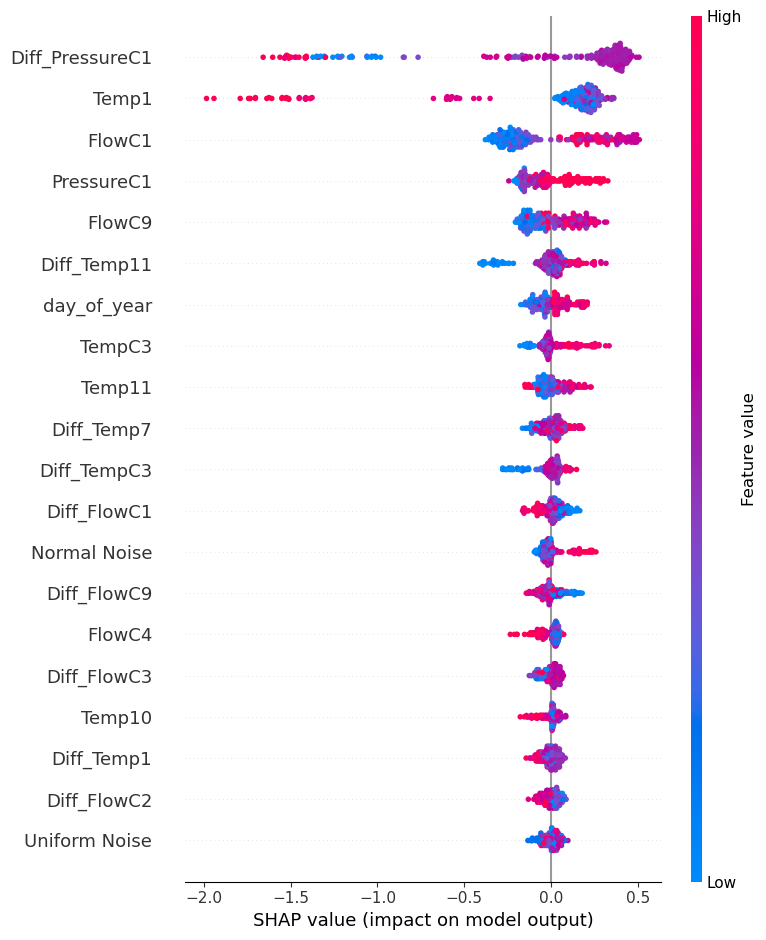

list of columns above noise ratio:  ['Diff_PressureC1', 'Temp1', 'FlowC1']
SHAP time [s]: 1.1


In [11]:
explainer_lgbm = shap.TreeExplainer(lgbm, feature_perturbation='tree_path_dependent') #by default if do not provide any backgound dataset: tree_path_dependent
shap_values_lgbm = explainer_lgbm.shap_values(X)

shap.summary_plot(shap_values_lgbm, X)

df_shap_values = pd.DataFrame(shap_values_lgbm, index=X.index, columns=X.columns)

shap_lgbm_abs = abs(shap_values_lgbm)

mean_shap = shap_lgbm_abs.mean(axis=0)
std_shap = shap_lgbm_abs.std(axis=0)

#for some features,shap values always equal to 0 --> mean_shap contains null values
#for the ones that are null put an extremely small values?
mean_shap[np.where(mean_shap==0)] = 1e-9
CoefVariance_shap = std_shap/mean_shap 

#table of the mean and std shap
df_global_shap_values = pd.DataFrame({'Tags':X.columns,
                     'mean':mean_shap,
                     'std':std_shap,
                     'CoefVariance':CoefVariance_shap})

df_global_shap_values.sort_values(by='mean', ascending=False, inplace=True)

col_list_by_mean_shap = df_global_shap_values['Tags'].tolist()

# Reodering cloumns by shap mean value
# X_original = X.copy()

X = X[col_list_by_mean_shap]
df_shap_values = df_shap_values[col_list_by_mean_shap]

list_ordered_factors = col_list_by_mean_shap
index_noise_shuffle = list_ordered_factors.index('Shuffle Yield Noise')
index_noise_normal = list_ordered_factors.index('Normal Noise')
index_noise_uni = list_ordered_factors.index('Uniform Noise')
min_index_noise = min(index_noise_shuffle,index_noise_normal,index_noise_uni)

col_name_noise = col_list_by_mean_shap[min_index_noise]
# Drop columns which SHAP average is below noise to ratio cut

# Gets the noise mean value
#noise_impact = float(df_global_shap_values['mean'].tail(1))
noise_impact = df_global_shap_values.set_index('Tags')['mean'][col_name_noise]
noise_cut_impact = signal_to_noise * noise_impact

# Finds columns with higher impact
bool_columns_after_noise_ratio_cut = df_global_shap_values['mean'].gt(noise_cut_impact)
col_list_after_noise_ratio_cut = df_global_shap_values[bool_columns_after_noise_ratio_cut]['Tags'].tolist()
print('list of columns above noise ratio: ', col_list_after_noise_ratio_cut)


# Appends noise column to visualize baseline
col_list_after_noise_ratio_cut.append(col_name_noise)

if 'SHAP_row_index' in col_list_after_noise_ratio_cut:
    # if a counter is important, this should be found by time index
    col_list_after_noise_ratio_cut.remove('SHAP_row_index')

# Alternative list with columns which SHAP average is just below noise (no noise ratio)
col_list_by_mean_shap_cut = col_list_by_mean_shap[0:(min_index_noise+1)]

X_SHAP_row_index = X['SHAP_row_index'].copy() # copy index before deleting
X.drop(['SHAP_row_index'], axis=1, inplace=True)


# X = X[col_list_by_mean_shap_cut]
X = X[col_list_after_noise_ratio_cut]

#X_normalized = (X-X.min())/(X.max()-X.min()) # not robust to outliers
X_normalized = (X-X.quantile(0.03))/(X.quantile(0.97)-X.quantile(0.03))
X_normalized = X_normalized.clip(0, 1)

# add SHAP row index again
#X_normalized['SHAP_row_index'] = X_SHAP_row_index

df_shap_values.drop(['SHAP_row_index'], axis=1, inplace=True)
# df_shap_values = df_shap_values[col_list_by_mean_shap_cut]
df_shap_values = df_shap_values[col_list_after_noise_ratio_cut]

# Full list until noise (no signal ratio used in case user wants to reduce it)
df_global_shap_values = df_global_shap_values.iloc[0:(min_index_noise+1),:]

toc = time.time() - tic
print('SHAP time [s]:', round(toc, 1))
tic = time.time()



In [12]:
# Tables for shap plots in JMP

if t_exists:
    df_shap_values = pd.concat([t, y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, t.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, t.name, y.name, 'tag', 'shap(value)'] 
    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)
    
else:
    df_shap_values = pd.concat([y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, y.name, 'tag', 'shap(value)'] 
                                    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)

df_shap_values.to_csv('../data/df_shap_values.csv')
df_global_shap_values.to_csv('../data/df_global_shap_values.csv')
df_shap_plot_table.to_csv('../data/df_shap_plot_table.csv')


toc = time.time() - tic
print('Exporting time [s]:', round(toc, 2))
tic = time.time()

Exporting time [s]: 0.04


In [13]:
df_shap_values

,SHAP_row_index,Date,yield,Diff_PressureC1,Temp1,FlowC1,Normal Noise
0,1,2016-08-21,69.400623,-0.124537,0.196068,0.143629,0.000332
1,2,2016-08-23,66.532666,-1.306125,0.112011,0.142412,-0.033074
2,3,2016-08-26,71.102193,0.433721,0.194264,0.208875,-0.001758
3,4,2016-08-29,69.793481,0.334118,0.168538,0.156678,-0.046570
4,5,2016-08-30,71.489516,0.432792,0.206462,0.325040,-0.018427
...,...,...,...,...,...,...,...
248,249,2019-01-26,69.037071,0.301432,0.222883,-0.279886,-0.001810
249,250,2019-01-28,69.202425,-0.035003,0.211282,-0.254954,-0.048090
250,251,2019-01-31,69.409546,0.355484,0.225489,-0.215401,-0.006305
251,252,2019-02-03,69.072711,0.348427,0.202880,-0.275733,-0.033216


In [14]:
y.name

'yield'

In [15]:
# df_shap_values.describe()

In [16]:
df_global_shap_values

,Tags,mean,std,CoefVariance
27,Diff_PressureC1,0.481435,0.390335,0.810776
5,Temp1,0.341842,0.418590,1.224512
6,FlowC1,0.254957,0.104428,0.409591
3,PressureC1,0.122054,0.073236,0.600026
16,FlowC9,0.116989,0.064135,0.548215
25,Diff_Temp11,0.083863,0.101654,1.212135
50,day_of_year,0.069447,0.050046,0.720639
10,TempC3,0.067181,0.070005,1.042024
1,Temp11,0.055873,0.045543,0.815108
38,Diff_Temp7,0.049476,0.038193,0.771952


In [17]:
#df_global_shap_values.describe()

In [18]:
df_shap_plot_table

,SHAP_row_index,Date,yield,tag,shap(value),value,norm(value)
0,1,2016-08-21,69.400623,Diff_PressureC1,-0.124537,NaN,NaN
1,2,2016-08-23,66.532666,Diff_PressureC1,-1.306125,-9.962800,0.003997
2,3,2016-08-26,71.102193,Diff_PressureC1,0.433721,-0.069500,0.488637
3,4,2016-08-29,69.793481,Diff_PressureC1,0.334118,0.225700,0.503097
4,5,2016-08-30,71.489516,Diff_PressureC1,0.432792,-0.167800,0.483821
...,...,...,...,...,...,...,...
1007,249,2019-01-26,69.037071,Normal Noise,-0.001810,-0.640023,0.325270
1008,250,2019-01-28,69.202425,Normal Noise,-0.048090,-1.159795,0.180860
1009,251,2019-01-31,69.409546,Normal Noise,-0.006305,0.660597,0.686626
1010,252,2019-02-03,69.072711,Normal Noise,-0.033216,-0.359954,0.403082


In [19]:
#df_shap_plot_table.describe()

#  END

In [20]:
# Packages intalled
!conda list 

# packages in environment at C:\ProgramData\Miniforge_JMP:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
abseil-cpp                20211102.0           h0e60522_0    conda-forge
absl-py                   1.2.0              pyhd8ed1ab_0    conda-forge
aiohttp                   3.8.1           py310he2412df_1    conda-forge
aiosignal                 1.2.0              pyhd8ed1ab_0    conda-forge
alembic                   1.8.1              pyhd8ed1ab_0    conda-forge
aom                       3.4.0                h0e60522_1    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310he2412df_2    conda-forge
asttokens                 2.0.8              pyhd8ed1ab_0    conda-forge
astunparse                1.6.3              pyhd8ed1ab_0    conda-forge
async-timeout             4.0.2              pyhd8ed1ab_0    conda-forge
attrs    